Studend: Nozomu Nakanishi
Student Id: 2020264
Github:
CA 2 - Big Data / Advanced Data Analytics - 17/11/23

- Importing the necessary libraries for the practical part.

In [60]:
from pyspark.sql import SparkSession
import sparknlp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import to_date, to_timestamp
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import lower
from pyspark.sql.functions import col, explode, expr, lit
from pyspark import StorageLevel

### Initializing Spark sessiong and Importing the dataset ProjectTweets.

In [1]:
# Initialize Spark Session with recommended settings for Spark NLP
spark = SparkSession.builder \
    .appName("ProjectTweets") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "com.johnsnowlabs.nlp.serialization.SparkNLPKryoRegistrator") \
    .getOrCreate()

In [2]:
# Defines the schema of the CSV file (ProjectTweets.csv) and adjust the field names and types for the dataframe.
tweetSchema = StructType([
    StructField("sequence", IntegerType(), True),
    StructField("ids", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
])

# Imports the dataset in csv format.
df = spark.read.csv("file:///home/hduser/Desktop/CA2/ProjectTweets.csv", header=False, schema=tweetSchema)

In [3]:
df.show(5, truncate=False)

+--------+----------+--------------------+--------+---------------+--------------------+
|sequence|       ids|                date|    flag|           user|                text|
+--------+----------+--------------------+--------+---------------+--------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|       6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|       7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|       8|1467811795|

In [ ]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

- As presented in the .show, the dataframe called df has 6 columns and 1.6 millions of observations. 

In [4]:
# Prints the df schema. 
df.printSchema()

# Which shows that the types of the data are ones set in previous steps.

root
 |-- sequence: integer (nullable = true)
 |-- ids: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



- It was observable that the dates have a pacific day time (PDT) and the present notebook it has a different time zone, thus setting the time zone to PDT.

In [5]:
# Sets the time zone to PDT, the same as the date column.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")

In [6]:
# Creating a new column where the date has a format that is better to perform analysis and models.
# Features like the day of the week and time zone are not necessary. 
date_format = "EEE MMM dd HH:mm:ss zzz yyyy"
# Parses the date e creates a new column dates with a shorter format, but with the necessary data. 
df = df.withColumn("dates", from_unixtime(unix_timestamp("date", date_format)))
df.show()

+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|sequence|       ids|                date|    flag|           user|                text|              dates|
+--------+----------+--------------------+--------+---------------+--------------------+-------------------+
|       0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009-04-06 22:19:45|
|       1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|2009-04-06 22:19:49|
|       2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|2009-04-06 22:19:53|
|       3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|2009-04-06 22:19:57|
|       4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|2009-04-06 22:19:57|
|       5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009-04-06 22:20:00|
|       6|146781159

### MISSING VALUES (TEXT COLUMN) AND DUPLICATES (TWITTER ID)

- The missing values will be searched through the tweets column, since the first objective is to extract the sentiment. 
- The duplicates will be searched through the twitter Id column, since is a unique identifier for each tweet, any duplicates will be further removed. 

In [10]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of missing values in 'text' column: 0


Number of duplicate ids: 1685


In [9]:
# To find duplicates based on the 'ids' column
duplicates_count = df.groupBy('ids').count().filter("`count` > 1").count()
print(f"Number of duplicate ids: {duplicates_count}")

Number of duplicate ids: 1685


In [11]:
df = df.dropDuplicates(['ids'])

# Now you can check the count of the DataFrame to ensure duplicates have been removed.
print(f"Count after dropping duplicates: {df.count()}")

Count after dropping duplicates: 1598315


- No presence of empty cells in the dataframe, however 1685 duplicates were found and removed. Reducing the number of observations to 1,598,315.

- Next step will drop columns that do not have purpose in the analysis and extraction.

In [12]:
df = df.drop("date", "ids", "user", "flag")
df.show()

+--------+--------------------+-------------------+
|sequence|                text|              dates|
+--------+--------------------+-------------------+
|       0|@switchfoot http:...|2009-04-06 22:19:45|
|       1|is upset that he ...|2009-04-06 22:19:49|
|       3|my whole body fee...|2009-04-06 22:19:57|
|       6|         Need a hug |2009-04-06 22:20:03|
|       8|@Tatiana_K nope t...|2009-04-06 22:20:05|
|       9|@twittera que me ...|2009-04-06 22:20:09|
|      12|@caregiving I cou...|2009-04-06 22:20:19|
|      15|@iamjazzyfizzle I...|2009-04-06 22:20:20|
|      18|@LettyA ahh ive a...|2009-04-06 22:20:31|
|      20|@alydesigns i was...|2009-04-06 22:20:37|
|      21|one of my friend ...|2009-04-06 22:20:38|
|      29|Meh... Almost Lov...|2009-04-06 22:21:04|
|      31|@alielayus I want...|2009-04-06 22:21:07|
|      33|@julieebaby awe i...|2009-04-06 22:21:11|
|      34|@HumpNinja I cry ...|2009-04-06 22:21:21|
|      35|ok I'm sick and s...|2009-04-06 22:21:20|
|      36|@c

- The column sequence was kept because it contains the original sequence of the dataframe, so in case of any shuffling the original sequence can be called. 

- Next stage will be performed the pre-processing of the tweets.  

# Pre-processing of the tweets and sentiment extraction.

- This step is separeted by two main lines of code, the first will normalized the tweets, by removing url, tags, mentions and character which has no meaning in sentiment extraction. The second is a pipeline from sparkNLP to generate and extract data that it is required to sentiment analysis over time and forecasting. 

- Both of the approaches will attempt to leverage the potential of Spark tools, such as the regex and the Natural Language Processing (NLP) tool, where it has numerous options from the simplest detection to deep learning. 

In [13]:
# Remove URLs
df = df.withColumn("text", F.regexp_replace(F.col("text"), "http(s)?://[^\\s]+", ""))

# Remove HTML tags
df = df.withColumn("text", F.regexp_replace(F.col("text"), "<[^>]+>", ""))

# Remove mentions (i.e., @username)
df = df.withColumn("text", F.regexp_replace(F.col("text"), "@\\w+", ""))

# Convert to lowercase
df = df.withColumn('text', lower(df['text']))

# Remove numbers from the "text" column
df = df.withColumn('text', regexp_replace(df['text'], r'\d+', ''))

# Reduce excessive characters (more than two of the same in a row)
df = df.withColumn('text', regexp_replace('text', r'(.)\1{2,}', r'\1\1'))

# Remove punctuation
df = df.withColumn('text', regexp_replace(df['text'], r"[^\w\s]", ""))

df.select("text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------+
|   a11 thats a bummer  you shoulda got david carr of third day to do it d                                                    |
|is upset that he cant update his facebook by texting it11 and might cry as a result  school today also blah                  |
| i dived many times for the ball managed to save   the rest go out of bounds                                                 |
|my whole body feels itchy and like its on fire                                                                               |
|need a hug                                                                                             

In [14]:
# Counts the entries with URLs.
url_count = df.filter(F.col("text").rlike("http(s)?://([\\w-]+\\.)+[\\w-]+(/[\\w- ./?%&=]*)?")).count()

# Counts the entries with HTML tags.
html_tags_count = df.filter(F.col("text").rlike("<[^>]+>")).count()

# Counts the entries with mentions (@username).
mentions_count = df.filter(F.col("text").rlike("@\\w+")).count()

print(f"Number of entries with URLs: {url_count}")
print(f"Number of entries with HTML tags: {html_tags_count}")
print(f"Number of entries with mentions: {mentions_count}")

Number of entries with URLs: 0
Number of entries with HTML tags: 0
Number of entries with mentions: 0


In [15]:
# Find the count of missing values in the 'text' column
missing_values_count = df.filter(df.text.isNull()).count()
print(f"Number of missing values in 'text' column: {missing_values_count}")

Number of missing values in 'text' column: 0


The last few lines of code shows that: 
- The final format is satisfatory to apply NLP techniques; 
- No mentions, tags, html were found after normalization;
- Also, no missing values were generated by the regex; 

### Natural Language Processing with SparkNLP library. 

The library chosen is based on a few factors. First, to extract the semtiment VADER approach , which is considered to be appropriate for social media content was attempt. However, erros related to out of memory and serialization led to the discard of the technique. And with many other options sparkNLP presented to be a good option, for memory efficiency and richness of NLP tasks. 
Overvall the choice of the library relies on: 
- It was built on top of Spark, thus is highly scalable and it is an appropriate choice for big dataframes, which is the case of this project, with more than a million tweets.
- It possess a vast number of operations, from the simplest to neural networks. The operations that are necessary to extract the data required can be achieved with only one library (memory effiency and consistency during transformations). 
- Pipeline, tasks can be perfomed with an optimized workflows through pipelines, reducing the number of codes to be called. 
- Pre-trained models, the library has models that are trained already that can be applied to other dataframes, in case of this project, to detect the language, spell checker, word embeddings and sentiment extraction techniques will be used. 

The codes and usage for the techniques and models were obtain through the SparkNLP documentation / annotadors. <br>
1.  https://sparknlp.org/docs/en/concepts <br>
2.  https://sparknlp.org/docs/en/annotators

The pipeline is composed by eight operations: 

1. The first is to transform the tweets into a document format that is going to be required in the next stages;

2. Not only to maintain the original context, many other operations in the pipeline needs the text at a sentence level to perform at best, in the present case, the tokenizer onwards is mainly using this format;

3. Tokenization of the tweets, the next techniques required that the text inputs are separeted;

4. In social media content is known to have many type of misspellings and the sparkNLP provides a few options to correct it <b>(1)</b>. The pre-trained chosen model is NorvigSweeting model, although the choice was made due to memory constrains.<b>(2)</b> 
- The first pre-trained approach attempted was the Context Spell Checker, a noisy channel model spell algorithm. However, the machine used for project resulted in running of out memory, the machine is not powerful enough to perform this model. 

The attempts of the following stages were performed back and forth until a workflow was accepted by the machine capabilities. To avoid repetition, the steps 5, 6 and 7 were chosen by the machine capabilities, although the experiments of each one will be listed below. 

5. Embedding the words using the method Glove (100 dimensions) to vectorize the tokens. One of the simplest model provided by the annotators. Numerous trials were performed using different techniques, roBERta, BERT, Universal Sentence Encoder (USC), but all returned the same error, out of memory. In addition, the choice of the embedding technique suffered influence of the next steps.

6. Sentiment is extract at a sentence level, therefore the word embedding need to be to be transformed.

7. The model that will predict the sentiment of the tweets is the sentimentDL using the pre-trained model on the Glove imdb (movies reviews). 
- The model is not the ideal for this dataframe, however, models like the sentimentdl_use_twitter were attempted however it required a type of embedding that the present machine could not perform the UCS. <b>(3)</b> Therefore, the extraction and embedding approaches were chosen to aim the most suitable for text and accepted by the machine memory. 


<b>(1):</b>https://medium.com/john-snow-labs/easily-correcting-typos-and-spelling-errors-on-texts-with-spark-nlp-and-python-1cffa3250f57 <br>
<b>(2):</b>https://sparknlp.org/docs/en/annotators#contextspellchecker <br>
<b>(3):</b>https://sparknlp.org/2021/01/18/sentimentdl_use_twitter_en.html

In [18]:
from sparknlp.annotator import *
from sparknlp.base import *

# 1. Document assembler.
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# 2. Sentence detector.
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# 3. Tokenize the tweets.
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# 4. Context-aware Spell Checker
spellChecker = NorvigSweetingModel.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("corrected")

# 5. Word Embedding with Glove (100 dimentions).
embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
    .setInputCols(["sentence", "corrected"]) \
    .setOutputCol("embeddings")

# 6. Convert word embeddings to sentence embeddings, which is required for the sentiment extraction model. 
sentence_embeddings = SentenceEmbeddings() \
    .setInputCols(["sentence", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

# 7. Use the SentimentDLModel compatible with GloVe embeddings (Threshold set 0.6 is also the default value)
sentiment_detector = SentimentDLModel.pretrained('sentimentdl_glove_imdb', 'en') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("sentiment") \
    .setThreshold(0.6) \

# 8. Finisher to convert annotations (the corrected tweets in token format and the sentiments) to DataFrame columns.
# The outputasarrys is set to false because by its defaults is true, however having as an array it means that an 
# extra operations (ie.:explode) will be required.
finisher = Finisher() \
    .setInputCols(["sentiment", "corrected"]) \
    .setOutputCols(["sentiment_result", "corrected_tweets"]) \
    .setOutputAsArray(False) \
    .setIncludeMetadata(True)  # Set to true because the sentiment scores are in the metadata.

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    spellChecker,
    embeddings,
    sentence_embeddings,
    sentiment_detector,
    finisher
])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[ — ]ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[ / ]Download done! Loading the resource.


[ | ]

2023-11-07 13:15:53.838569: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]
spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ / ]spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ | ]Download done! Loading the resource.
[ / ]

[ — ]

[ \ ]

[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
Download done! Loading the resource.
[OK!]
sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ — ]sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[ \ ]Download done! Loading the resource.


[ | ]

[OK!]


- The pipeline will be applied and the results will be the addition of the columns with the corrected text (token format) and the sentiment (score and polarity) along with the metadata.
<br><br>
- The persist is being called in this line of code for a few reasons: 
1. Jupyter getting slow and memory issues starting to appear after the pipeline.
2. The dataframe suffered transformations up to this point and it will have more additional tasks after the pipeline, therefore to avoid the calculation of the workflow the technique will be applied. Note: cache was also attempted but the memory itself was not enough, thus sharing the dataframe between disk and memory.

In [19]:
# Apply the pipeline to the DataFrame
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)
df.persist(StorageLevel.MEMORY_AND_DISK)
df.count()
# Display the results
df.show()

2023-11-07 15:01:32,976 WARN memory.MemoryStore: Not enough space to cache rdd_160_96 in memory! (computed 1252.3 KiB so far)
2023-11-07 15:01:33,008 WARN storage.BlockManager: Persisting block rdd_160_96 to disk instead.
2023-11-07 15:02:50,968 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_98 in memory.
2023-11-07 15:02:51,534 WARN memory.MemoryStore: Not enough space to cache rdd_160_98 in memory! (computed 0.0 B so far)
2023-11-07 15:02:51,534 WARN storage.BlockManager: Persisting block rdd_160_98 to disk instead.
2023-11-07 15:05:02,151 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_100 in memory.
2023-11-07 15:05:02,943 WARN memory.MemoryStore: Not enough space to cache rdd_160_100 in memory! (computed 0.0 B so far)
2023-11-07 15:05:02,943 WARN storage.BlockManager: Persisting block rdd_160_100 to disk instead.
2023-11-07 15:07:01,802 WARN memory.MemorySto

2023-11-07 15:45:02,655 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_138 in memory.
2023-11-07 15:45:03,319 WARN memory.MemoryStore: Not enough space to cache rdd_160_138 in memory! (computed 0.0 B so far)
2023-11-07 15:45:03,321 WARN storage.BlockManager: Persisting block rdd_160_138 to disk instead.
2023-11-07 15:47:01,326 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_140 in memory.
2023-11-07 15:47:02,021 WARN memory.MemoryStore: Not enough space to cache rdd_160_140 in memory! (computed 0.0 B so far)
2023-11-07 15:47:02,022 WARN storage.BlockManager: Persisting block rdd_160_140 to disk instead.
2023-11-07 15:49:01,118 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_142 in memory.
2023-11-07 15:49:01,980 WARN memory.MemoryStore: Not enough space to cache rdd_160_142 in memory! (computed 0.0 B s

2023-11-07 16:28:25,656 WARN memory.MemoryStore: Not enough space to cache rdd_160_182 in memory! (computed 0.0 B so far)
2023-11-07 16:28:25,656 WARN storage.BlockManager: Persisting block rdd_160_182 to disk instead.
2023-11-07 16:30:30,248 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_184 in memory.
2023-11-07 16:30:30,910 WARN memory.MemoryStore: Not enough space to cache rdd_160_184 in memory! (computed 0.0 B so far)
2023-11-07 16:30:30,910 WARN storage.BlockManager: Persisting block rdd_160_184 to disk instead.
2023-11-07 16:32:43,009 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_160_186 in memory.
2023-11-07 16:32:43,697 WARN memory.MemoryStore: Not enough space to cache rdd_160_186 in memory! (computed 0.0 B so far)
2023-11-07 16:32:43,698 WARN storage.BlockManager: Persisting block rdd_160_186 to disk instead.
2023-11-07 16:34:55,686 WARN memory.MemorySto

+--------+--------------------+-------------------+---------------+----------------+------------------------+-------------------------+
|sequence|                text|              dates|language_result|sentiment_result|language_result_metadata|sentiment_result_metadata|
+--------+--------------------+-------------------+---------------+----------------+------------------------+-------------------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|           [en]|           [pos]|    [{fr, 3.586327E-1...|     [{sentence, 0}, {...|
|     159|oh  just got all ...|2009-04-06 22:30:50|           [en]|       [neutral]|    [{fr, 4.642191E-1...|     [{sentence, 0}, {...|
|     493|crap i need more ...|2009-04-06 22:52:59|           [en]|           [neg]|    [{fr, 8.2225286E-...|     [{sentence, 0}, {...|
|     598|i had a horrible ...|2009-04-06 23:01:14|           [en]|           [neg]|    [{fr, 0.0}, {lv, ...|     [{sentence, 0}, {...|
|  800822| hells to the no ...|2009-04-06 23:03:

# VISUALIZE THE DATAFRAME.......SHOW()

- The sentiment column with the metadata does not have the overall score of the sentiment, thus the next line of code will calculate the final score. 

In [23]:
# Extract positive and negative scores
df = df.withColumn("positive_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'pos')[0]._2"))
df = df.withColumn("negative_score", expr("filter(sentiment_result_metadata, x -> x._1 == 'neg')[0]._2"))

# Calculate sentiment score by subtracting the negative score from the positive score
df = df.withColumn("sentiment_score", col("positive_score") - col("negative_score"))

# Show the resulting DataFrame with sentiment score
df.select("text", "sentiment_result", "sentiment_score", "language_result").show()

+--------------------+----------------+-------------------+---------------+
|                text|sentiment_result|    sentiment_score|language_result|
+--------------------+----------------+-------------------+---------------+
|  not forever11 s...|           [pos]|        0.982639662|           [en]|
|oh  just got all ...|       [neutral]|0.03298530000000005|           [en]|
|crap i need more ...|           [neg]|       -0.994555624|           [en]|
|i had a horrible ...|           [neg]|      -0.9991101201|           [en]|
| hells to the no ...|           [pos]|         0.47807643|           [en]|
|  the mint ones a...|           [pos]|          0.8148422|           [en]|
| shut up you11i a...|           [pos]|       0.9971133619|           [en]|
|i dont like lukew...|           [pos]|   0.99999982835387|           [en]|
|got a great first...|           [pos]| 0.9999966465818001|           [en]|
|would love to str...|           [pos]|    0.9999845035235|           [en]|
|jade is loo

In [25]:
df.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- language_result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment_result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- language_result_metadata: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _1: string (nullable = true)
 |    |    |-- _2: string (nullable = true)
 |-- sentiment_result_metadata: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _1: string (nullable = true)
 |    |    |-- _2: string (nullable = true)
 |-- positive_score: string (nullable = true)
 |-- negative_score: string (nullable = true)
 |-- sentiment_score: double (nullable = true)



In [26]:
df = df.drop("language_result_metadata", "sentiment_result_metadata", "positive_score", "negative_score")
df.show()

+--------+--------------------+-------------------+---------------+----------------+-------------------+
|sequence|                text|              dates|language_result|sentiment_result|    sentiment_score|
+--------+--------------------+-------------------+---------------+----------------+-------------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|           [en]|           [pos]|        0.982639662|
|     159|oh  just got all ...|2009-04-06 22:30:50|           [en]|       [neutral]|0.03298530000000005|
|     493|crap i need more ...|2009-04-06 22:52:59|           [en]|           [neg]|       -0.994555624|
|     598|i had a horrible ...|2009-04-06 23:01:14|           [en]|           [neg]|      -0.9991101201|
|  800822| hells to the no ...|2009-04-06 23:03:23|           [en]|           [pos]|         0.47807643|
|  801106|  the mint ones a...|2009-04-06 23:18:16|           [en]|           [pos]|          0.8148422|
|     868| shut up you11i a...|2009-04-06 23:18:59|    

In [29]:
df = df.drop("language_result", "sentiment_result")
df.show()

+--------+--------------------+-------------------+-------------------+--------+---------+
|sequence|                text|              dates|    sentiment_score|language|sentiment|
+--------+--------------------+-------------------+-------------------+--------+---------+
|      68|  not forever11 s...|2009-04-06 22:23:28|        0.982639662|      en|      pos|
|     159|oh  just got all ...|2009-04-06 22:30:50|0.03298530000000005|      en|  neutral|
|     493|crap i need more ...|2009-04-06 22:52:59|       -0.994555624|      en|      neg|
|     598|i had a horrible ...|2009-04-06 23:01:14|      -0.9991101201|      en|      neg|
|  800822| hells to the no ...|2009-04-06 23:03:23|         0.47807643|      en|      pos|
|  801106|  the mint ones a...|2009-04-06 23:18:16|          0.8148422|      en|      pos|
|     868| shut up you11i a...|2009-04-06 23:18:59|       0.9971133619|      en|      pos|
|     918|i dont like lukew...|2009-04-06 23:23:03|   0.99999982835387|      en|      pos|

# APPLY LANGUAGE DETECTOR

- The language detector was included in the pipeline, however the option used did not yield good performance regarding the results. Thus, the language detector will be called in the next step.

# EDA ON THE TEXT COLUMN
token counts 
word frequency
word cloud
etc...

In [ ]:
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))

df.show()

In [ ]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

In [ ]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the Spark DataFrame to a Pandas DataFrame
# The dataframe with the total number of tweets per day is not large so it is feasible to transform it to Pandas.
pandas_df = tweets_per_day.toPandas()

plt.figure(figsize=(15, 8))

# Plot the bars for days with data.
plt.bar(pandas_df['daily_records'], pandas_df['count'], width=0.8)

# Set the x-axis to cover the full date range, including days without tweets.
start_date = pandas_df['daily_records'].min()
end_date = pandas_df['daily_records'].max()
plt.xlim(start_date, end_date)

# Rotate the x-axis labels for readability.
plt.xticks(rotation=90)

# Set the x-axis major locator and formatter.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set title and labels.
plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')

# Ensure everything fits without overlapping.
plt.tight_layout()

# Show plot with grid.
plt.grid(True)
plt.show()

# EDA FOR SENTIMENT FORECASTING - SENTIMENT POLATIRY AND SCORE

In [61]:
# Calculate the total number of tweets
total_count = df.count()

# Group by the 'sentiment' column and count the occurrences
frequency_df = df.groupBy("sentiment").count()

# Calculate the frequency in percentage
frequency_percent_df = frequency_df.withColumn(
    "frequency_percent", 
    (col("count") / lit(total_count) * 100)
)

# Show the result
frequency_percent_df.show()

+---------+------+------------------+
|sentiment| count| frequency_percent|
+---------+------+------------------+
|      pos|851123| 53.35853130395422|
|      neg|702885| 44.06520711528166|
|  neutral| 41094|2.5762615807641143|
+---------+------+------------------+



In [34]:
df.describe("sentiment_score").show()

+-------+-------------------+
|summary|    sentiment_score|
+-------+-------------------+
|  count|            1595102|
|   mean|0.09433735979403485|
| stddev|  0.929044807975337|
|    min|               -1.0|
|    max|                1.0|
+-------+-------------------+



In [35]:
df = df.withColumn("daily_records", to_date(col("dates"), 'yyyy-MM-dd'))

# Convert the dates column from string to timestamp
df = df.withColumn("dates", to_timestamp(col("dates"), 'yyyy-MM-dd HH:mm:ss'))

df.show()

+--------+--------------------+-------------------+-------------------+--------+---------+-------------+
|sequence|                text|              dates|    sentiment_score|language|sentiment|daily_records|
+--------+--------------------+-------------------+-------------------+--------+---------+-------------+
|      68|  not forever11 s...|2009-04-06 22:23:28|        0.982639662|      en|      pos|   2009-04-06|
|     159|oh  just got all ...|2009-04-06 22:30:50|0.03298530000000005|      en|  neutral|   2009-04-06|
|     493|crap i need more ...|2009-04-06 22:52:59|       -0.994555624|      en|      neg|   2009-04-06|
|     598|i had a horrible ...|2009-04-06 23:01:14|      -0.9991101201|      en|      neg|   2009-04-06|
|  800822| hells to the no ...|2009-04-06 23:03:23|         0.47807643|      en|      pos|   2009-04-06|
|  801106|  the mint ones a...|2009-04-06 23:18:16|          0.8148422|      en|      pos|   2009-04-06|
|     868| shut up you11i a...|2009-04-06 23:18:59|    

In [65]:
# Temporal Distribution: Count tweets per day
tweets_per_day = df.groupby('daily_records').count()
tweets_per_day.show()

+-------------+------+
|daily_records| count|
+-------------+------+
|   2009-05-13|  4055|
|   2009-06-25| 19663|
|   2009-05-01|  7691|
|   2009-06-15|109461|
|   2009-06-07| 96011|
|   2009-05-03| 35214|
|   2009-06-24|  6285|
|   2009-05-11|  4178|
|   2009-05-27|   837|
|   2009-04-17|  3076|
|   2009-06-20| 45282|
|   2009-04-20| 18405|
|   2009-06-22| 11986|
|   2009-04-21|  8572|
|   2009-05-23|   169|
|   2009-05-25|   169|
|   2009-06-01|109860|
|   2009-04-19| 27394|
|   2009-05-18| 36368|
|   2009-06-21| 16327|
+-------------+------+
only showing top 20 rows



In [66]:
# Number of rows
num_rows = tweets_per_day.count()

# Number of columns
num_columns = len(tweets_per_day.columns)

# Print out the shape
print(f"The DataFrame shape is: ({num_rows}, {num_columns})")

The DataFrame shape is: (48, 2)


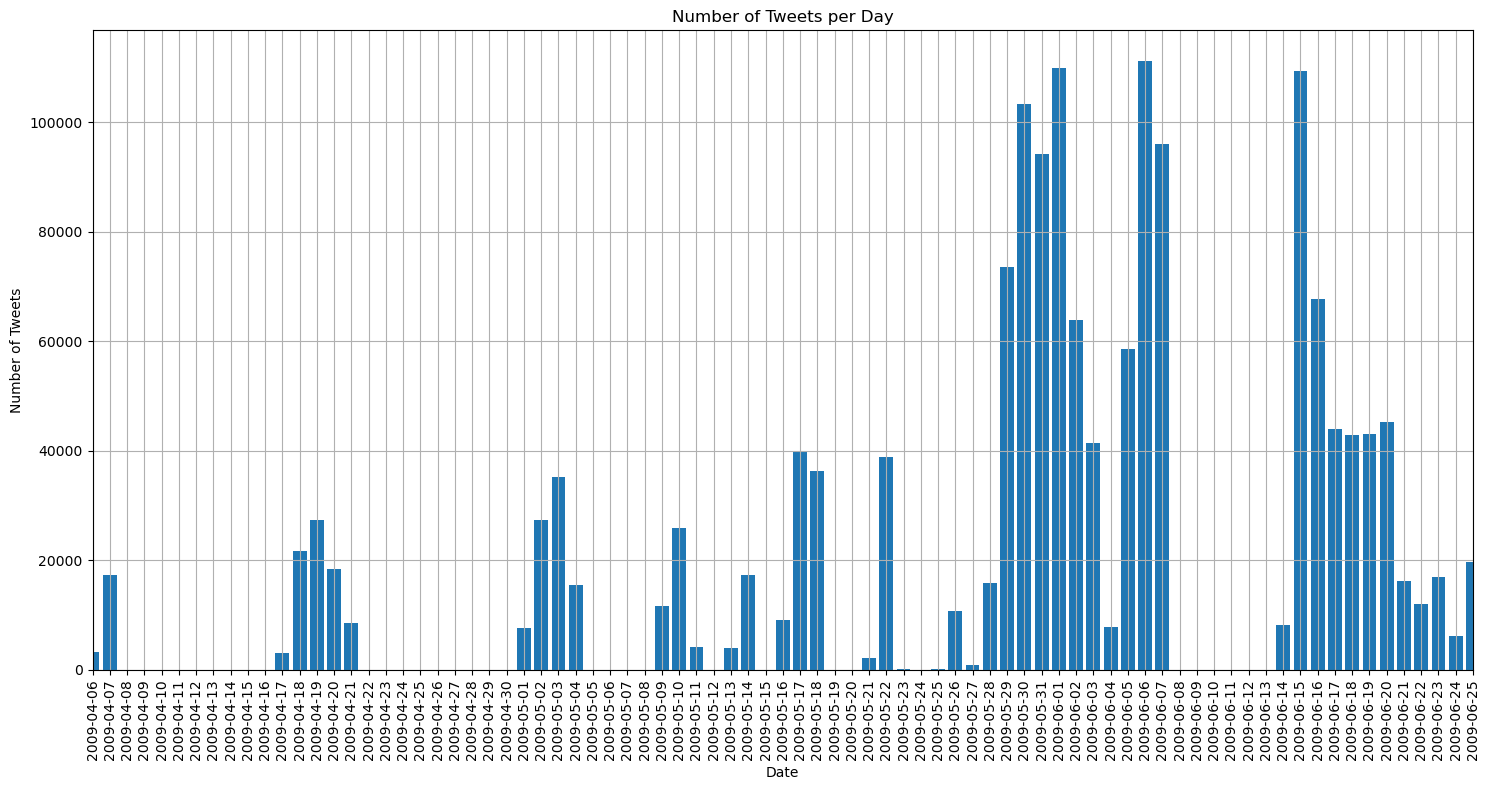

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the Spark DataFrame to a Pandas DataFrame
# The dataframe with the total number of tweets per day is not large so it is feasible to transform it to Pandas.
pandas_df = tweets_per_day.toPandas()

plt.figure(figsize=(15, 8))

# Plot the bars for days with data.
plt.bar(pandas_df['daily_records'], pandas_df['count'], width=0.8)

# Set the x-axis to cover the full date range, including days without tweets.
start_date = pandas_df['daily_records'].min()
end_date = pandas_df['daily_records'].max()
plt.xlim(start_date, end_date)

# Rotate the x-axis labels for readability.
plt.xticks(rotation=90)

# Set the x-axis major locator and formatter.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set title and labels.
plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')

# Ensure everything fits without overlapping.
plt.tight_layout()

# Show plot with grid.
plt.grid(True)
plt.show()

In [81]:
# Create a date range that spans all days from the earliest to the latest date in pandas_df
full_date_range = pd.date_range(start=pandas_df['daily_records'].min(), end=pandas_df['daily_records'].max())

# Convert the 'daily_records' in pandas_df to a set for faster lookup
recorded_dates = set(pandas_df['daily_records'])

# Find dates that are in the full range but not in the recorded dates
missing_dates = full_date_range.difference(recorded_dates)

# Output the missing dates
num_missing_dates = len(missing_dates)
missing_dates = sorted(missing_dates)  # Sort the dates for clarity

print(f"Number of days without tweets: {num_missing_dates}")
print("Days without tweets:")
for day in missing_dates:
    print(day.strftime('%Y-%m-%d'))  # Format the date as a string for display


Number of days without tweets: 33
Days without tweets:
2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-12
2009-05-15
2009-05-19
2009-05-20
2009-05-24
2009-06-08
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13


In [36]:
# Group by 'daily_records' and calculate the average sentiment score
daily_sentiment_avg = df.groupBy('daily_records').agg(F.avg('sentiment_score').alias('average_sentiment'))

# You can also calculate the sum if that's more relevant for your analysis
daily_sentiment_sum = df.groupBy('daily_records').agg(F.sum('sentiment_score').alias('total_sentiment'))

# Show the result to verify
daily_sentiment_avg.show()


+-------------+--------------------+
|daily_records|   average_sentiment|
+-------------+--------------------+
|   2009-05-13| 0.11084810334025949|
|   2009-06-25|-0.11917005775121654|
|   2009-05-01|  0.1258235851055851|
|   2009-06-15| 0.11277365334443072|
|   2009-06-07| 0.14325790524808388|
|   2009-05-03|  0.1238384263807547|
|   2009-06-24|-0.09173642722901808|
|   2009-05-11| 0.09481371555010619|
|   2009-05-27|  0.0721874748321542|
|   2009-04-17| 0.15735256667617648|
|   2009-06-20|-0.09373040551262102|
|   2009-04-20| 0.11974381900697725|
|   2009-06-22| -0.0823464303807123|
|   2009-04-21| 0.11612730999056578|
|   2009-05-23| 0.08814905475225927|
|   2009-05-25| 0.23953315052507582|
|   2009-06-01| 0.11891642059833077|
|   2009-04-19| 0.13980354378489346|
|   2009-05-18|  0.1252474669164208|
|   2009-06-21|-0.07600716433777442|
+-------------+--------------------+
only showing top 20 rows



In [82]:
df.unpersist()

DataFrame[sequence: int, text: string, dates: timestamp, sentiment_score: double, language: string, sentiment: string, daily_records: date]

In [ ]:
# Write the DataFrame to a CSV file in the local file system of the Spark driver node
df.write.csv('file:///home/hduser/Desktop/CA2/pro_tweets.csv', header=True)